## This model will clasify a potato leaf has any common disease.
Version 01 :
1. Model : Transfered (EfficientNetB0)
2. Diseaseses : 6 (bacteria / fungi / nematode / pest / phytopthora / virus )
3. Dataset : Potato_bacteria_fungi_nematode_pest_phytopthora_virus_dataset

In [1]:
# Import libraries

import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv

In [2]:
PATH = 'Datasets//Potato_bacteria_fungi_nematode_pest_phytopthora_virus_dataset'
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANELS = 3
EPOCHS = 60

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3076 files belonging to 7 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']

In [5]:
N_CLASSES = len(class_names)
N_CLASSES

7

2025-12-25 10:12:46.370507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


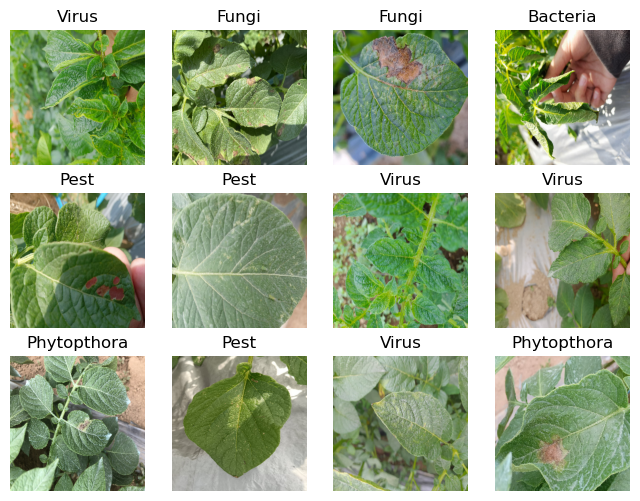

In [6]:
plt.figure(figsize=(8,6))

for image_batch, lable_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[lable_batch[i]])
        plt.axis('off')

In [13]:
#Split the data set into train, test and validation sets.

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    
    num_batches = len(ds)
    train_size = int(num_batches*train_split)
    val_size = int(num_batches*val_split)

    if shuffle:
        ds.shuffle(shuffle_size, seed=12)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    print('Data partitions are created.')
    print(f'Train size = {len(train_ds)} \nValidation size = {len(val_ds)} \nTest size = {len(test_ds)}')

    return train_ds, val_ds, test_ds

In [15]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset)

Data partitions are created.
Train size = 77 
Validation size = 9 
Test size = 11


In [17]:
#Set datasets to be cached and work with multi processing

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
#Resize any given image to 256x256 and sacle teh image values to 0:1

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [30]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

### Model bulding, Training and Evaluating

In [33]:
def save_model(model, name, model_version):
    model.save(f'Models//{name}//{model_version}.keras')
    print('Model saved succesfully')

In [35]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

base_model.trainable = False

In [41]:
model_1 = tf.keras.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(N_CLASSES, activation="softmax"),
])

model_1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [49]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=8, restore_best_weights=True, verbose=1
    )
]



history = model_1.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

save_model(model_1, 'potato_common_diseases_transfered_model', '1')

Epoch 1/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 52s 570ms/step - accuracy: 0.2066 - loss: 1.8778 - val_accuracy: 0.2604 - val_loss: 1.7923 - learning_rate: 1.0000e-04
Epoch 2/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - accuracy: 0.2029 - loss: 1.8142 - val_accuracy: 0.2604 - val_loss: 1.7881 - learning_rate: 1.0000e-04
Epoch 3/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 35s 451ms/step - accuracy: 0.2094 - loss: 1.8122 - val_accuracy: 0.2604 - val_loss: 1.7843 - learning_rate: 1.0000e-04
Epoch 4/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 35s 451ms/step - accuracy: 0.2256 - loss: 1.8073 - val_accuracy: 0.2604 - val_loss: 1.7855 - learning_rate: 1.0000e-04
Epoch 5/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 35s 452ms/step - accuracy: 0.2086 - loss: 1.8162 - val_accuracy: 0.2604 - val_loss: 1.7866 - learning_rate: 1.0000e-04
Epoch 6/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.2361 - loss: 1.7989
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 445ms/step - accuracy:

In [51]:
score = model_1.evaluate(test_ds)
score

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - accuracy: 0.2623 - loss: 1.7596


[1.759576439857483, 0.26234567165374756]

Text(0.5, 1.0, 'Training and Validation loss')

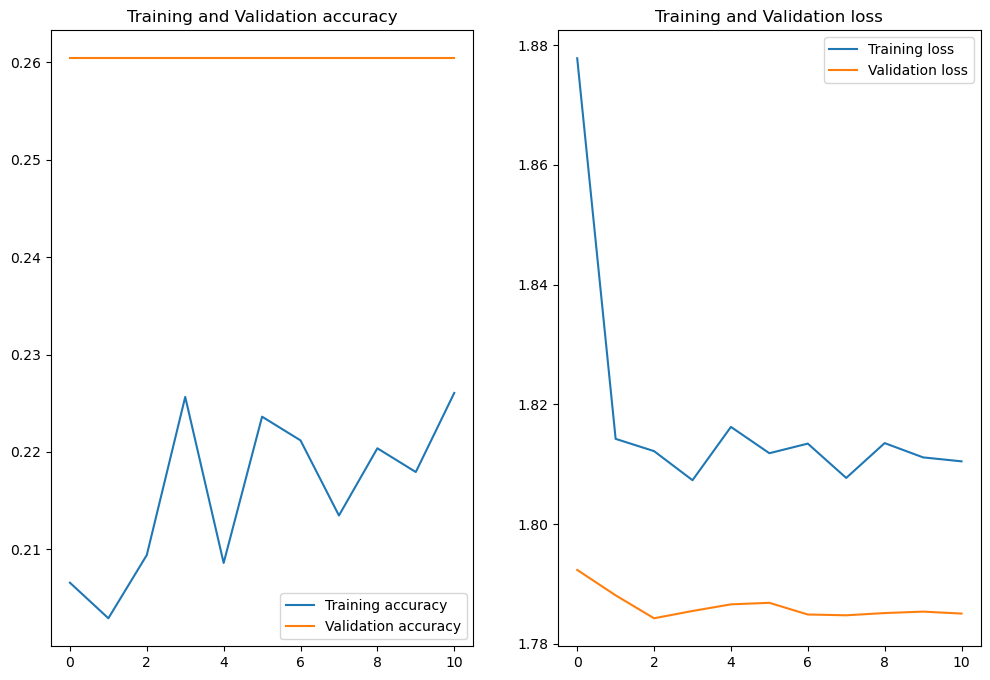

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.plot(range(11), acc, label='Training accuracy')
plt.plot(range(11), val_acc, label='Validation accuracy')
plt.legend()
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(11), loss, label='Training loss')
plt.plot(range(11), val_loss, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')